# LSTM Implementation and Experiments

This notebook demonstrates the LSTM implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [33]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from src.models.src.models.lstm.nusax_loader import NusaXLoader
from src.models.src.models.lstm.experiments import LSTMExperiments
from src.models.src.models.lstm.lstm_model import LSTMModel
from src.models.src.models.lstm.lstm_layer import LSTMLayer
from src.models.src.models.lstm.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [35]:
# MacOS GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


## 1. Load Data

In [36]:
# Initialize the data loader
data_loader = NusaXLoader(batch_size=32)

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Decode a few examples
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', 'yang', 'di', 'dan', 'tidak', 'saya', 'dengan', 'enak', 'ini', 'makan', 'untuk', 'ke', 'tempat', 'makanan', 'juga', 'sangat', 'ada', 'banyak', 'karena']

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with LSTM

In [37]:
experiments = LSTMExperiments(data_loader=data_loader,batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of LSTM Layers


=== Training model with 1 LSTM Layer ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4261 - loss: 1.0860 - val_accuracy: 0.3800 - val_loss: 1.0882
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3466 - loss: 1.0965 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3976 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3344 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3638 - loss: 1.0825 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3461 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3740 - loss: 1.0814 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3406 - loss: 1.0816 - val_accuracy: 0.3800 - val_loss: 1.

/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4113 - loss: 1.0891 - val_accuracy: 0.3800 - val_loss: 1.0917
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3422 - loss: 1.0971 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3839 - loss: 1.0816 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3669 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3507 - loss: 1.0843 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3569 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3257 - loss: 1.0848 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3970 - loss: 1.0804 - val_accuracy: 0.3800 - val_loss: 1.

/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4086 - loss: 1.0900 - val_accuracy: 0.3800 - val_loss: 1.0830
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3440 - loss: 1.0902 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3697 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3655 - loss: 1.0794 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3619 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3571 - loss: 1.0822 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3907 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3420 - loss: 1.0851 - val_accuracy: 0.3800 - val_loss: 1.

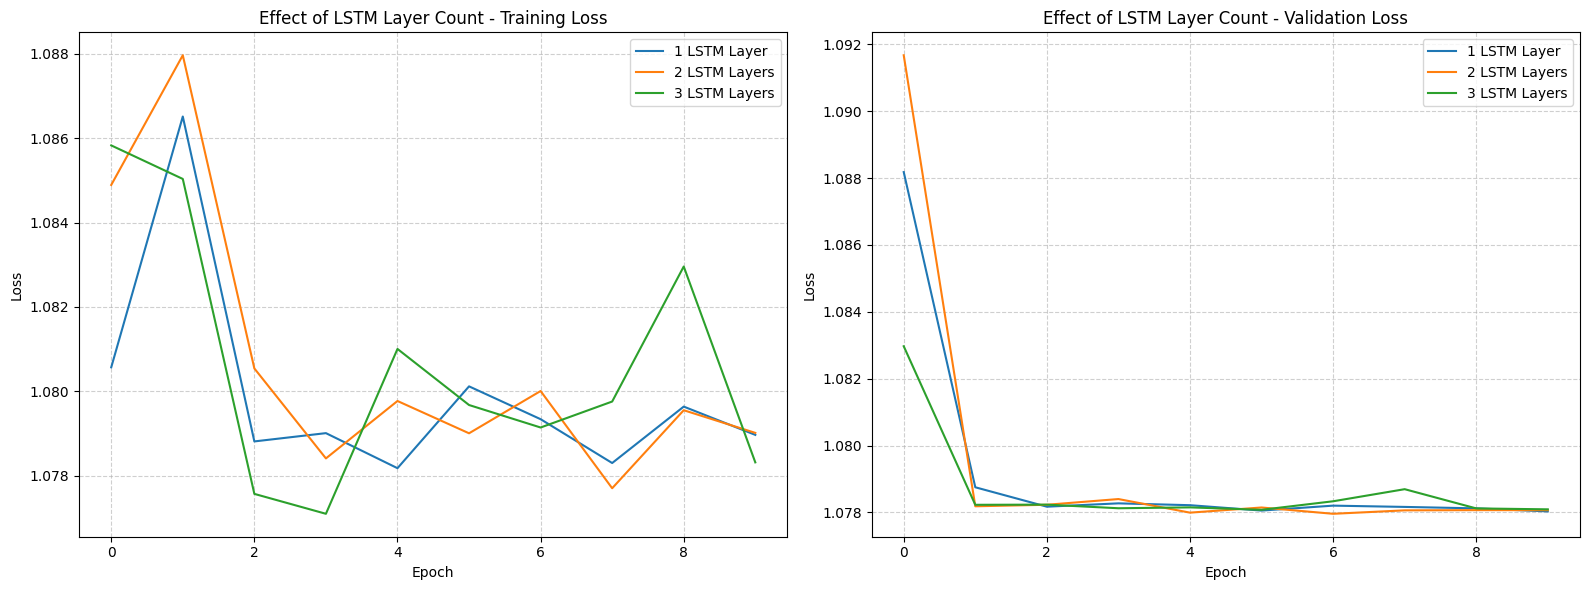

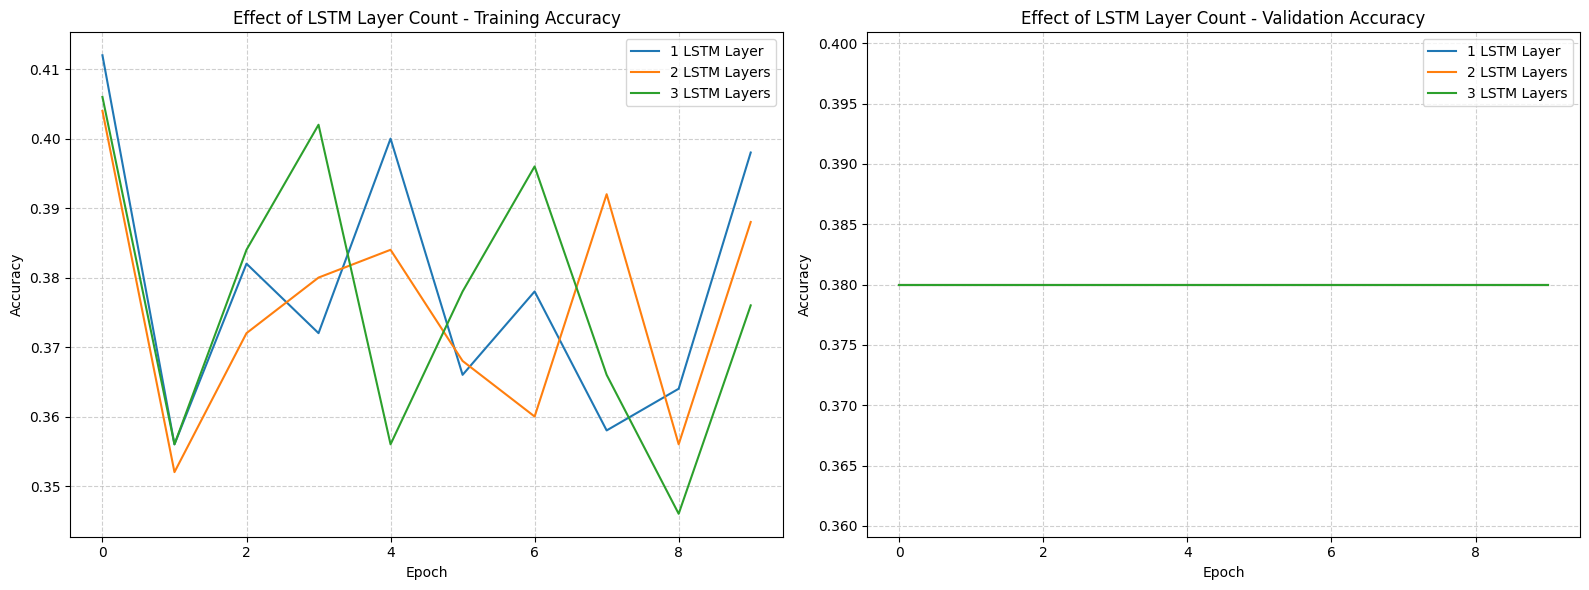

In [38]:
# Define variants for number of LSTM layers
layer_count_variants = [
    (1, "1 LSTM Layer"),
    (2, "2 LSTM Layers"),
    (3, "3 LSTM Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of LSTM Cells per Layer


=== Training model with 64 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3850 - loss: 1.0906 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3408 - loss: 1.0846 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3722 - loss: 1.0828 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3575 - loss: 1.0818 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3660 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3642 - loss: 1.0843 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3653 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3492 - loss: 1.0809 - val_accuracy: 0.3800 - val_loss: 1.

/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4057 - loss: 1.0881 - val_accuracy: 0.3800 - val_loss: 1.0850
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3412 - loss: 1.0902 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3826 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3438 - loss: 1.0821 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3701 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3610 - loss: 1.0804 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3326 - loss: 1.0827 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3221 - loss: 1.0825 - val_accuracy: 0.3800 - val_loss: 1.

/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3984 - loss: 1.0921 - val_accuracy: 0.3800 - val_loss: 1.0881
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3432 - loss: 1.0947 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3327 - loss: 1.0818 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3401 - loss: 1.0846 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3602 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3301 - loss: 1.0830 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3444 - loss: 1.0823 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3328 - loss: 1.0834 - val_accuracy: 0.3800 - val_loss: 1.

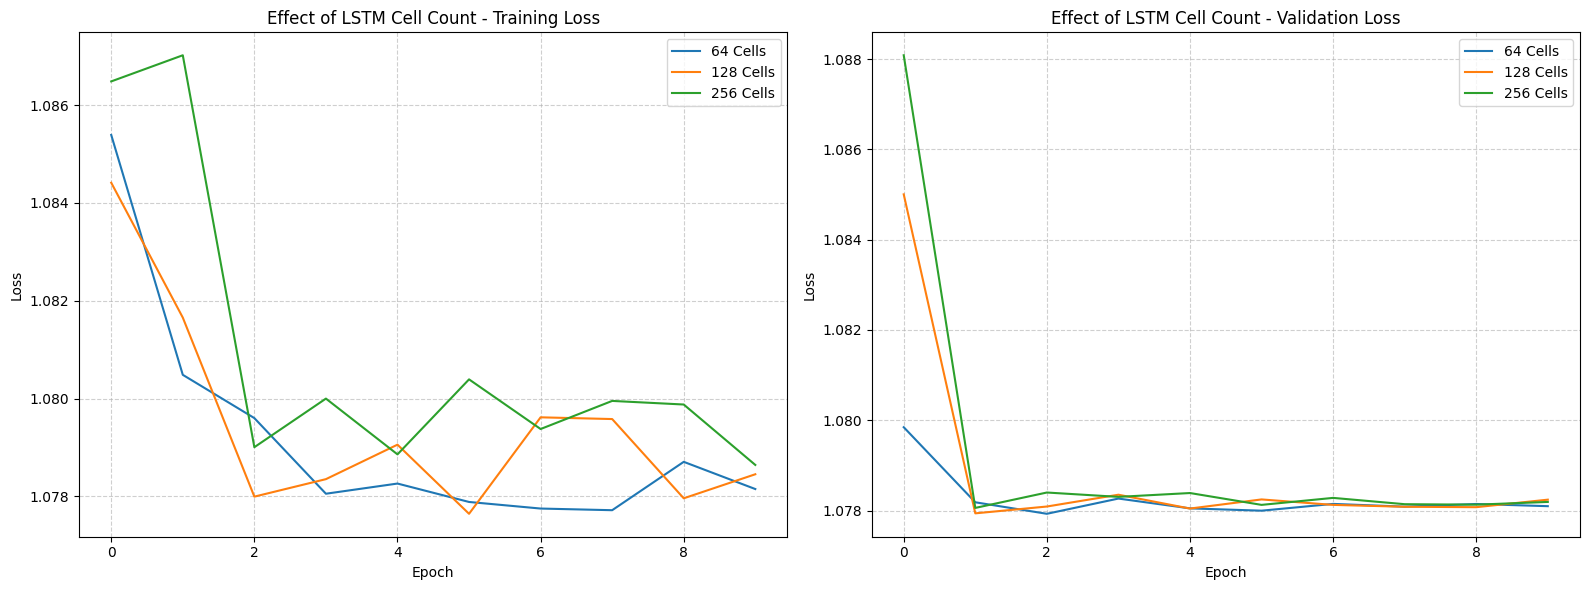

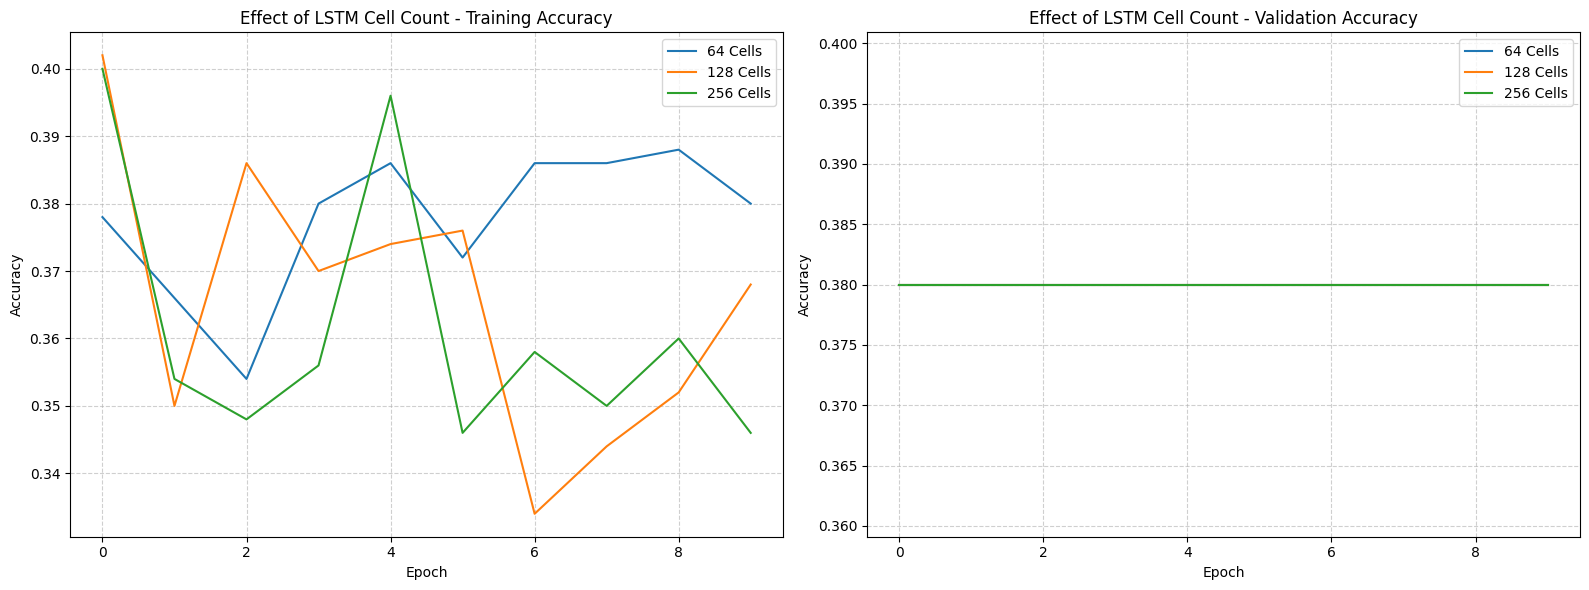

In [39]:
# Define variants for cell counts
cell_count_variants = [
    ([64], "64 Cells"),
    ([128], "128 Cells"),
    ([256], "256 Cells")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)


### 2.3 Experiment: LSTM Direction


=== Training model with Unidirectional LSTM ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4009 - loss: 1.0877 - val_accuracy: 0.3800 - val_loss: 1.0844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3414 - loss: 1.0926 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3722 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3662 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3496 - loss: 1.0837 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3345 - loss: 1.0838 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3304 - loss: 1.0834 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3436 - loss: 1.0809 - val_accuracy: 0.3800 - val_loss: 1.

/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4195 - loss: 1.0754 - val_accuracy: 0.5500 - val_loss: 1.0067
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5513 - loss: 0.9355 - val_accuracy: 0.5600 - val_loss: 0.9227
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7079 - loss: 0.7217 - val_accuracy: 0.6600 - val_loss: 0.8006
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8428 - loss: 0.4622 - val_accuracy: 0.6600 - val_loss: 0.8650
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9337 - loss: 0.2483 - val_accuracy: 0.7200 - val_loss: 0.7549
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9532 - loss: 0.1919 - val_accuracy: 0.7600 - val_loss: 0.8195
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9656 - loss: 0.1117 - val_accuracy: 0.7700 - val_loss: 0.8497
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9784 - loss: 0.0833 - val_accuracy: 0.7100 - val_loss: 0.

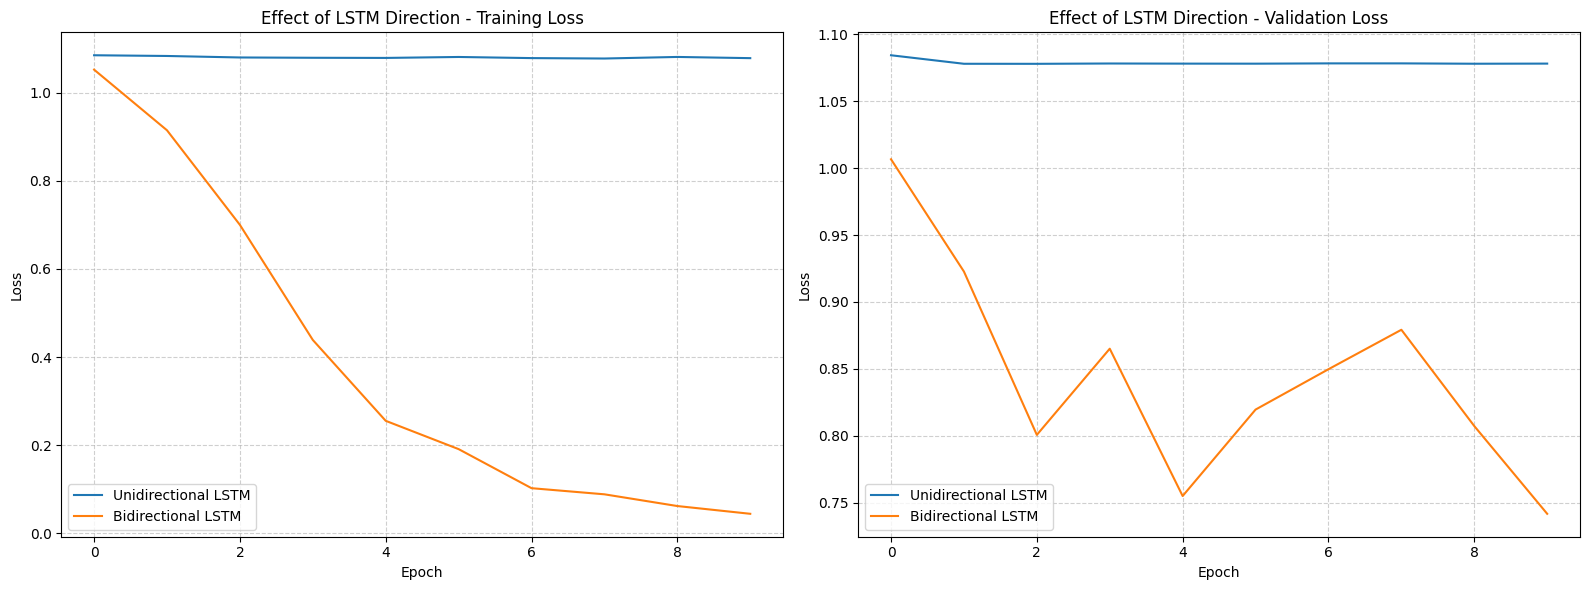

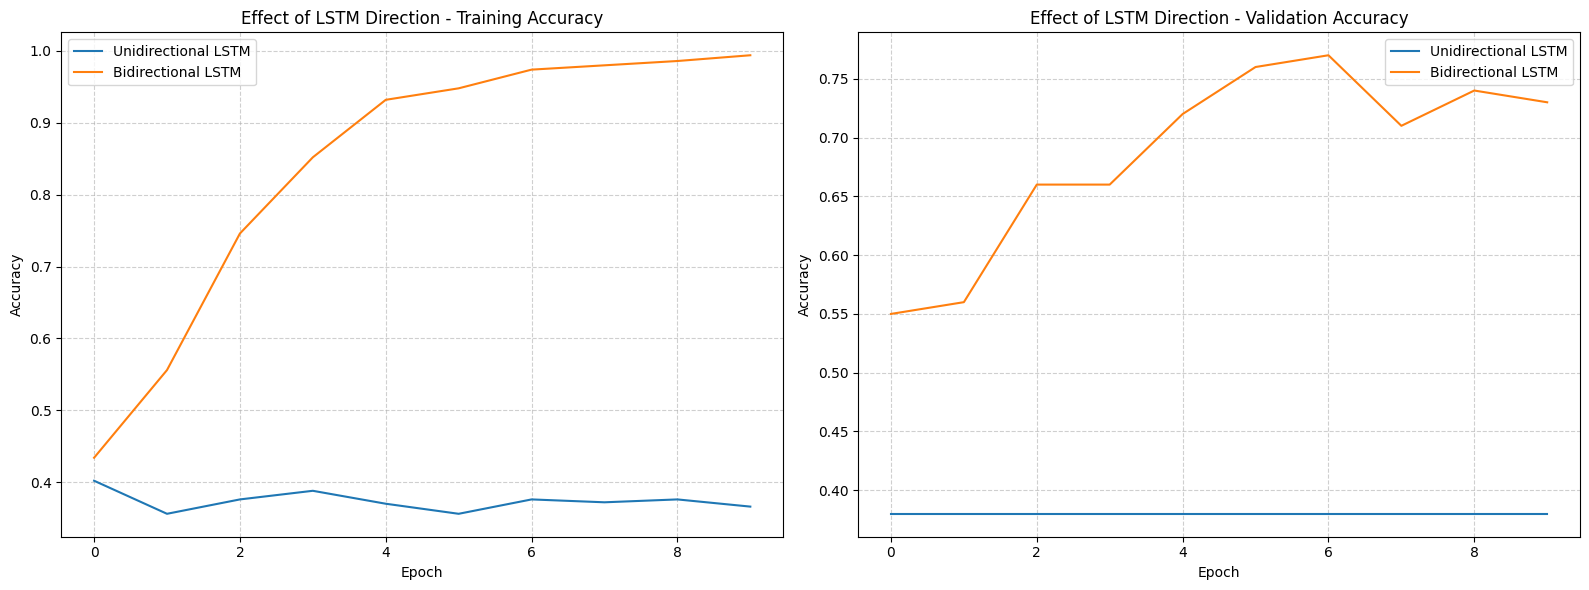

In [40]:
# Define variants for LSTM direction
direction_variants = [
    (False, "Unidirectional LSTM"),
    (True, "Bidirectional LSTM")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)


## 3. From-Scratch LSTM Implementation

In [41]:
# Choose one of the trained models (e.g., from the bidirectional experiment)
keras_model = direction_models[1][0]  # Bidirectional LSTM model

# Summary of the chosen model
keras_model.summary()

# Save the model weights
keras_model.save_weights('lstm_model.weights.h5')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,603 (5.94 MB)

 Trainable params: 518,867 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,037,736 (3.96 MB)

In [42]:
# Get embedding dimension and vocabulary size
embedding_dim = 100
vocab_size = len(data_loader.get_vocabulary())
hidden_dim = 128
num_classes = data_loader.num_classes
sequence_length = data_loader.max_sequence_length

# Create a from-scratch LSTM model that matches the Keras model
scratch_model = LSTMModel()

# Add layers corresponding to the Keras model architecture
scratch_model.add(EmbeddingLayer(input_dim=vocab_size, output_dim=embedding_dim))
scratch_model.add(LSTMLayer(input_dim=embedding_dim, hidden_dim=hidden_dim, bidirectional=True))
scratch_model.add(DropoutLayer(dropout_rate=0.2))
scratch_model.add(DenseLayer(input_dim=hidden_dim*2, output_dim=num_classes, activation=Softmax()))

# Load weights from the Keras model
scratch_model.load_weights_from_keras(keras_model)

print("Weights loaded from Keras model to from-scratch implementation.")

Weights loaded from Keras model to from-scratch implementation.


In [43]:
# Get test data
x_test, y_test = data_loader.get_vectorized_data('test')

# Compare predictions
comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=32)

print("\nKeras Model Metrics:")
print(f"Accuracy: {comparison['keras_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['keras_metrics']['macro_f1']:.4f}")

print("\nFrom-Scratch Model Metrics:")
print(f"Accuracy: {comparison['scratch_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['scratch_metrics']['macro_f1']:.4f}")

print(f"\nModel Agreement: {comparison['model_agreement']:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Keras Model Metrics:
Accuracy: 0.7575
Macro F1-Score: 0.7554

From-Scratch Model Metrics:
Accuracy: 0.7600
Macro F1-Score: 0.7579

Model Agreement: 0.9950


In [45]:
# Get a few test samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
sample_texts = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions with both models
keras_preds = np.argmax(keras_model.predict(sample_texts), axis=1)
scratch_preds = scratch_model.predict(sample_texts)

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Visualize the results
for i in range(num_samples):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_texts[i] if idx > 0]
    text = " ".join(words)
    
    # Show true label and predictions
    keras_correct = keras_preds[i] == sample_labels[i]
    scratch_correct = scratch_preds[i] == sample_labels[i]
    
    print(f"\nText: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"True sentiment: {sentiment_labels[sample_labels[i]]}")
    print(f"Keras prediction: {sentiment_labels[keras_preds[i]]} {'✓' if keras_correct else '✗'}")
    print(f"Scratch prediction: {sentiment_labels[scratch_preds[i]]} {'✓' if scratch_correct else '✗'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Text: musim hujan begini setiap hujan pasti tidak tenang takut [UNK]
True sentiment: Negative
Keras prediction: Neutral ✗
Scratch prediction: Neutral ✗

Text: menunggu makanannya lama banget [UNK] [UNK] pas makanannya saat itu saya pesan pizza datang eh [UNK]...
True sentiment: Negative
Keras prediction: Negative ✓
Scratch prediction: Negative ✓

Text: [UNK] indomie pertama di 2018 ku semalam ternyata nikmat
True sentiment: Positive
Keras prediction: Neutral ✗
Scratch prediction: Neutral ✗

Text: harus coba untuk bersantai atau makan malam di the [UNK] ini pemandangan yang [UNK] baik dan yang me...
True sentiment: Positive
Keras prediction: Positive ✓
Scratch prediction: Positive ✓

Text: cukup mudah mencari lokasi ini tinggal mengikuti saja arah ke tengah kota [UNK] di [UNK] jalan terli...
True sentiment: Positive
Keras prediction: Negative ✗
Scratch prediction: Negative ✗
